In [3]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from astropy.cosmology import Planck15 as cosmo
from IPython.display import display, clear_output

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "sigma8": 0.8102,
    "H0": 67.66
    #"A_s": As
}

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

######################################################
#  Configuring the run
######################################################

N = 1              #Number of basis functions in each test
zmin_pert = 300    #min and max redshift of perturbations
zmax_pert = 2500
ll_max = 2500
linear_sampling = 20000  #number of timesteps during recombination

amplitudes = np.linspace(-.1, .1, 5)
middle = int((amplitudes.shape[0]-1)/2)

Npert = 80
z_of_pert = np.linspace(zmin_pert, zmax_pert, Npert)
dz = (zmax_pert - zmin_pert)/Npert
width=dz/2.355/3.  #dz is 1/3 the FWHM

plancklike=True

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   #'A_s':standard_params["A_s"]
                   'sigma8': standard_params["sigma8"],
                   'n_s':standard_params["n_s"],
                   'tau_reio': standard_params["tau_reio"],
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   #'recombination': 'RECFAST',
                   'perturb_xe': 'yes',
                   'xe_pert_num': N,
                   'zmin_pert': zmin_pert,
                   'zmax_pert': zmax_pert,
                   'thermo_Nz_lin': linear_sampling,
                   'xe_single_width': width
                   #'use_spline_xe_pert': 'yes'
                   }  

def create_outdir(basename):
    now = datetime.now()
    d1 = now.strftime("%b%d")
    filebase = os.path.join(os.path.dirname(os.getcwd()), 'data')+"/"+d1+"."+basename+".0"
    i=0
    while(os.path.exists(filebase)):
        split = filebase.split(".")
        filebase=".".join(split[:-1])+".{}".format(i)
        i+=1
    os.mkdir(filebase)
    print("Created directory {}".format(filebase))
    return filebase

def write_log():
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    logname = os.path.join(filebase ,"{}.log".format(basename))
    with open(logname, 'w') as file:
        now = datetime.now()
        file.write("# Files in this directory created {}\n".format(date_time))
        file.write("{\n")
        for k,v in common_settings.items():
            file.write("{0} {1}\n".format(k,v))
        file.write("}\n")
        file.write("N {}\n".format(N))
        file.write("zmin {}\n".format(zmin_pert))
        file.write("zmax {}\n".format(zmax_pert))
        file.write("ll_max {}\n".format(ll_max))
        file.write("linear_sampling {}\n".format(linear_sampling))
        file.write("Npert {}\n".format(Npert))
        zstr = ",".join(z_of_pert.astype(str))
        file.write("pivots {}\n".format(zstr))
        file.write("dz {}\n".format(dz))
        file.write("width {}\n".format(width))
        file.write("Planck_Noise {}".format(plancklike))

M = Class.Class()
M.set(common_settings)

True

In [4]:
basename="H0Mode"
filebase = create_outdir(basename)
write_log()

tt_derivs = []
te_derivs = []
ee_derivs = []

perts = []
z_array = []

run_count = 0
run_total = z_of_pert.shape[0]*amplitudes.shape[0]

#dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

print("{0} of {1} runs completed\r".format(run_count, run_total))

for zi in z_of_pert:
    
    M.set({'xe_single_zi': zi})

    tt_array = []
    te_array = []
    ee_array = []

    for qi in amplitudes:
        amp_str = "{}".format(qi)        #Setting up string of perturbation amplitudes
        M.set({'xe_pert_amps': amp_str}) #sets perturbation
        M.compute()

        cls = M.lensed_cl(ll_max)
        tt_array.append(cls['tt'][2:])
        te_array.append(cls['te'][2:])
        ee_array.append(cls['ee'][2:])

        if(qi==amplitudes[-1]):
            perts.append(M.get_thermodynamics()['xe_pert'])
            if(zi==z_of_pert[-1]):
                z_array.append(M.get_thermodynamics()['z'])
        
        run_count+=1
        clear_output(wait=True)
        print("{0} of {1} runs completed\r".format(run_count, run_total))

    tt_array = np.vstack(tt_array)
    te_array = np.vstack(te_array)
    ee_array = np.vstack(ee_array)
    spacing = amplitudes[1]-amplitudes[0]
    tt_grad = np.gradient(tt_array, spacing, axis=0)
    te_grad = np.gradient(te_array, spacing, axis=0)
    ee_grad = np.gradient(ee_array, spacing, axis=0)
    tt_derivs.append(tt_grad[middle])
    te_derivs.append(te_grad[middle])
    ee_derivs.append(ee_grad[middle])

tt_derivs = np.vstack(tt_derivs)    
te_derivs = np.vstack(te_derivs)    
ee_derivs = np.vstack(ee_derivs)    

z_array = np.array(z_array)

np.save(os.path.join(filebase,"tt_derivs"), tt_derivs)
np.save(os.path.join(filebase,"te_derivs"), te_derivs)
np.save(os.path.join(filebase,"ee_derivs"), ee_derivs)
np.save(os.path.join(filebase,"pivots"), z_of_pert)
np.save(os.path.join(filebase,"z"), z_array)

print("tt_derivs shape: {}".format(tt_derivs.shape))
print("te_derivs shape: {}".format(te_derivs.shape))
print("ee_derivs shape: {}".format(ee_derivs.shape))
print("zi length: {}".format(z_of_pert.shape))

400 of 400 runs completed
tt_derivs shape: (80, 2499)
te_derivs shape: (80, 2499)
ee_derivs shape: (80, 2499)
zi length: (80,)


In [5]:
# these need to be defined but since amplitude is zero there is no actually perturbation
M.set({'xe_single_width': width})
M.set({'xe_single_zi': zmin_pert})
M.set({'xe_pert_amps': '0'})

inc_perc = .05 #percentage that standard parameters are incremented by 

#dCls with respect to standard cosmological parameters
s_tt_derivs = []
s_te_derivs = []
s_ee_derivs = []

#varying standard parameters
for param, value in standard_params.items():
    print("fiducial {} value {}".format(param,value))
    dp = inc_perc*value
    varied_params = np.linspace(-2*dp, 2*dp, 5) + value
    print(varied_params)
    tt_array=[]
    te_array=[]
    ee_array=[]
    
    for new_value in varied_params:
        M.set({param: new_value}) #sets perturbation
        M.compute()
        cls = M.lensed_cl(ll_max)
        tt_array.append(cls['tt'][2:])
        te_array.append(cls['te'][2:])
        ee_array.append(cls['ee'][2:])
    
    tt_array = np.vstack(tt_array)
    te_array = np.vstack(te_array)
    ee_array = np.vstack(ee_array)
    s_tt_derivs.append(np.gradient(tt_array, dp, axis=0)[middle])
    s_te_derivs.append(np.gradient(te_array, dp, axis=0)[middle])
    s_ee_derivs.append(np.gradient(ee_array, dp, axis=0)[middle])

s_tt_derivs = np.vstack(s_tt_derivs)    
s_te_derivs = np.vstack(s_te_derivs)    
s_ee_derivs = np.vstack(s_ee_derivs)    

fiducial omega_b value 0.02242
[0.020178 0.021299 0.02242  0.023541 0.024662]
fiducial omega_cdm value 0.11933
[0.107397  0.1133635 0.11933   0.1252965 0.131263 ]
fiducial n_s value 0.9665
[0.86985  0.918175 0.9665   1.014825 1.06315 ]
fiducial tau_reio value 0.0561
[0.05049  0.053295 0.0561   0.058905 0.06171 ]
fiducial sigma8 value 0.8102
[0.72918 0.76969 0.8102  0.85071 0.89122]
fiducial H0 value 67.66
[60.894 64.277 67.66  71.043 74.426]


In [6]:
M.set({'xe_single_width': width})
M.set({'xe_single_zi': zmin_pert})
M.set({'xe_pert_amps': '0'})
for key,val in standard_params.items():
    M.set({key: val})
M.compute() ##Run CLASS
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
#Tcmb=1.0
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2
tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]

total_tt_derivs = np.concatenate((s_tt_derivs, tt_derivs))
total_te_derivs = np.concatenate((s_te_derivs, te_derivs))
total_ee_derivs = np.concatenate((s_ee_derivs, ee_derivs))

The noise properties can be described by a noise map $N_{X,\ell}^i = w_{X,i}^{-1} B_i^{-2}$ where $w_{X,i}$ is the angular resolution and $B_i = \exp{(-\ell^2 \sigma_{b,i}^2 / 2)}$ and $\sigma_b$ is the beam width for the $ith$ frequency channel. From Table 12 of [[1]](https://arxiv.org/pdf/1807.06207.pdf), we have the following values:

|                       |      143 GHz       |       217 GHz      |
|:---------------------:|:------------------:|:------------------:|
| FWHM (radians)         |       0.0021         |            0.001425   |
| $w_T^{-1/2}$ $(\mu K)$| 9.5993·10<sup>-3<sup>| 1.36·10<sup>-2<sup>|
| $w_P^{-1/2}$ $(\mu K)$| 2.042·10<sup>-2<sup>| 3.054<sup>-2<sup>|
    
To implement this, we can replace:

$$
C^X_{\ell} \to C^X_\ell + N_{X,\ell}
$$
where $N_{X,\ell} = \sum_i N^i_{X,\ell}$ is the sum over channels.


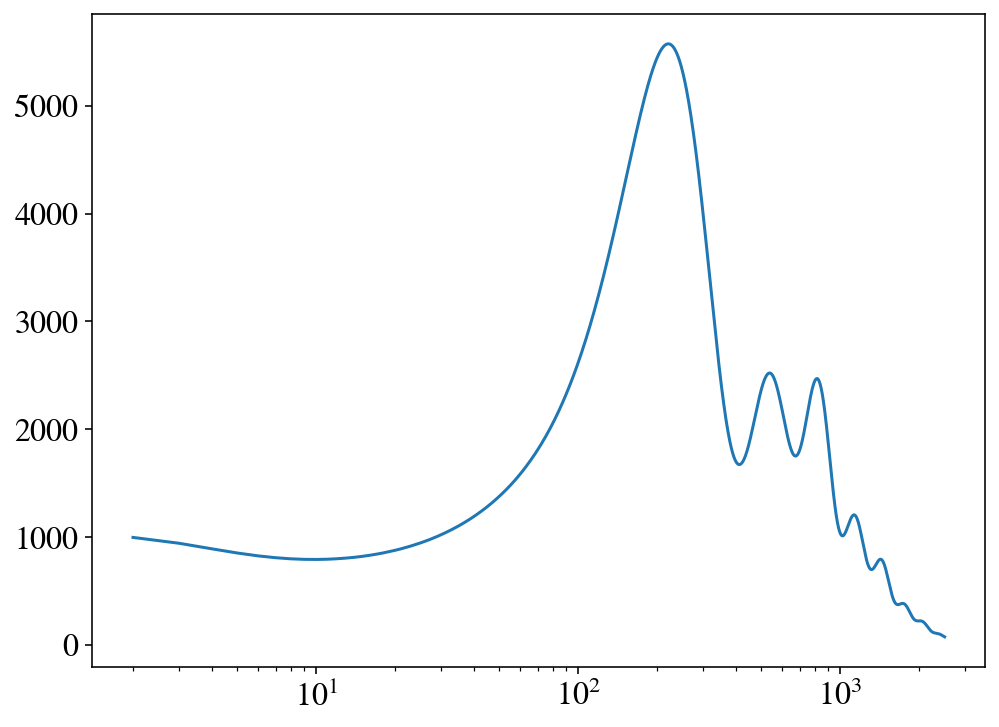

In [7]:
if(plancklike):
    beam_width_143 = (.0021)/(2*np.sqrt(2*np.log(2))) ##7.22/2.355 arcmin in radians
    beam_width_217 = (.001425)/(2*np.sqrt(2*np.log(2))) ## 4.90/2.355 arcmin in radians
    T_sens_143 = (9.5993e-3)**2 ## w^-1 micro-K^2
    T_sens_217 = (1.36e-2)**2 ## w^-1 micro-K^2
    P_sens_143 = (2.042e-2)**2 ##micro-K^2
    P_sens_217 = (3.054e-2)**2 ##micro-K^2
    B_143 = np.exp(-ll*ll*beam_width_143**2) # B^2
    B_217 = np.exp(-ll*ll*beam_width_217**2)
    #Nl_T = T_sens_143*B_143 + T_sens_217*B_217 #adding noise from both channels
    #Nl_P = P_sens_143*B_143 + P_sens_217*B_217 #adding noise from both channels
    Nl_T = 1.0/(T_sens_143**(-1.0)*B_143 + T_sens_217**(-1.0)*B_217)
    Nl_P = 1.0/(P_sens_143**(-1.0)*B_143 + P_sens_217**(-1.0)*B_217)
    row1 = np.stack([(tt_fid+Nl_T)**2, te_fid**2, (tt_fid+Nl_T)*te_fid], axis=1)
    row2 = np.stack([te_fid**2, (ee_fid+Nl_P)**2, te_fid*(ee_fid+Nl_P)], axis=1)
    row3 = np.stack([(tt_fid+Nl_T)*te_fid, te_fid*(ee_fid+Nl_P), 0.5*(te_fid**2 + (tt_fid+Nl_T)*(ee_fid+Nl_P))], axis=1)
else:
    row1 = np.stack([tt_fid**2, te_fid**2, tt_fid*te_fid], axis=1)
    row2 = np.stack([te_fid**2, ee_fid**2, te_fid*ee_fid], axis=1)
    row3 = np.stack([tt_fid*te_fid, te_fid*ee_fid, 0.5*(te_fid**2 + tt_fid*ee_fid)], axis=1)

fig,ax=plt.subplots()
ax.plot(ll, tt_fid*ll*(ll+1)/2./np.pi)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

sigmal = np.stack([row1, row2, row3], axis=1)

for i, ell in enumerate(ll):
    sigmal[i]*=(2./(2*ell + 1))

dCl = muK2*np.stack([total_tt_derivs, total_ee_derivs, total_te_derivs], axis=1)

(80, 3, 2499)
55.0
3025.0
2200
27.5


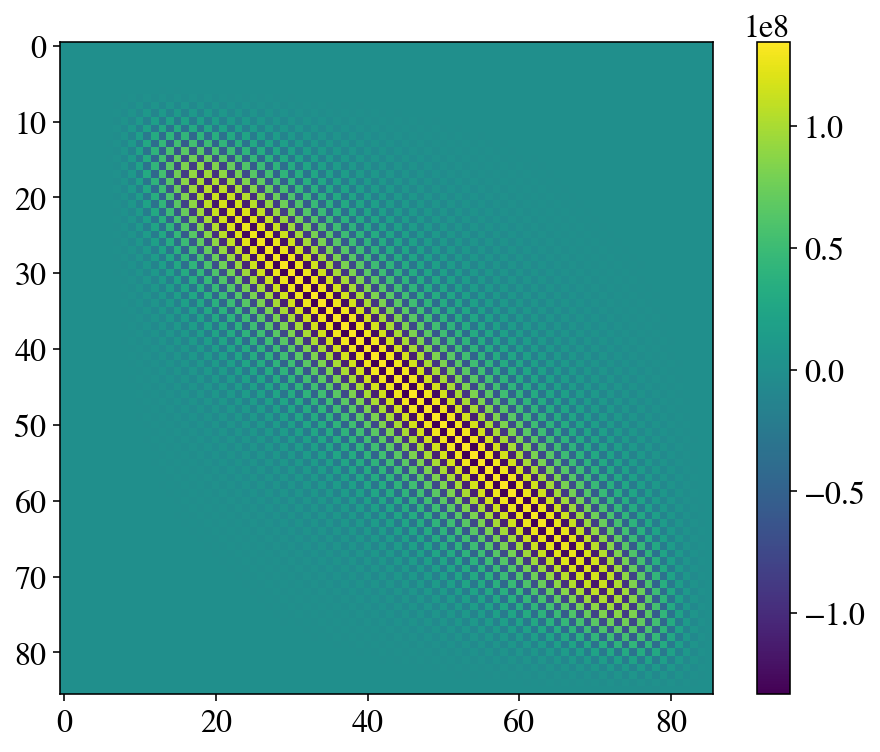

In [275]:
from matplotlib.colors import LogNorm
from matplotlib import cm
print(dCl[6:].shape)
import scipy.interpolate
sigma_inv = np.linalg.inv(sigmal)
fsky = 0.8
Fisher = fsky*np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

Fprior_block = np.zeros((Npert,Npert))

sig_prior = 2*dz
#sig_prior = 75.160371
#sig_prior=76
print(sig_prior)
print(sig_prior**2)
print(zmax_pert - zmin_pert)

for i in np.arange(Npert):
    for j in np.arange(Npert):
        Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(z_of_pert[i]-z_of_pert[j])**2/sig_prior**2)
        #Fprior_block[i,j] = np.exp(-(z_of_pert[i]-z_of_pert[j])**2/sig_prior**2)

Fprior_block = np.linalg.pinv(Fprior_block)
print(dz)
Fprior = np.zeros(Fisher.shape)
Fprior[6:, 6:] = Fprior_block

Fisher+=Fprior

fig,ax=plt.subplots()

m=ax.imshow(Fprior, origin='upper', cmap=cm.viridis)
fig.colorbar(m)

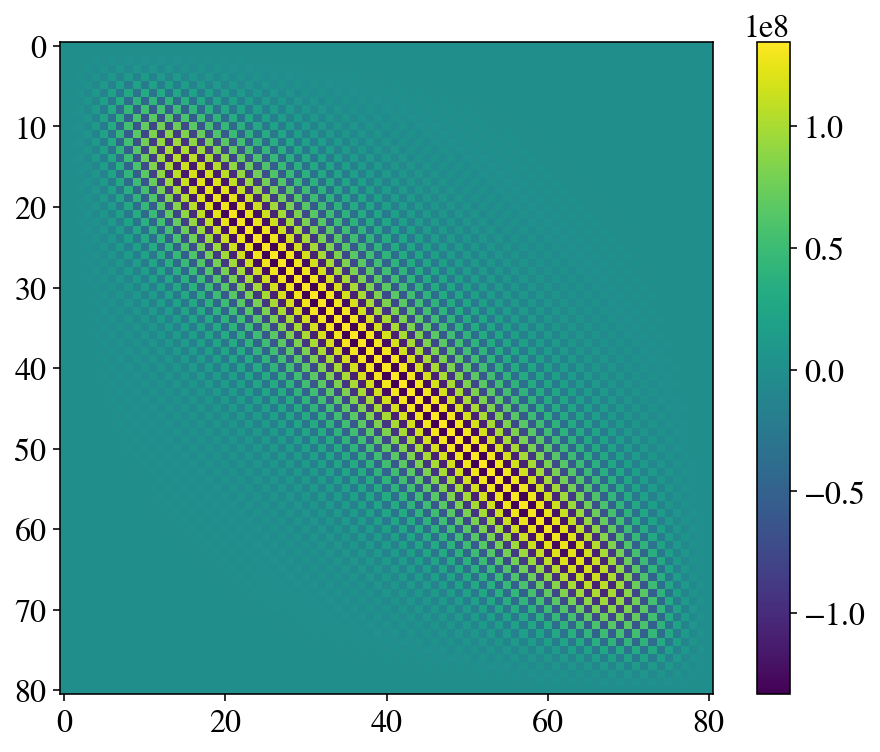

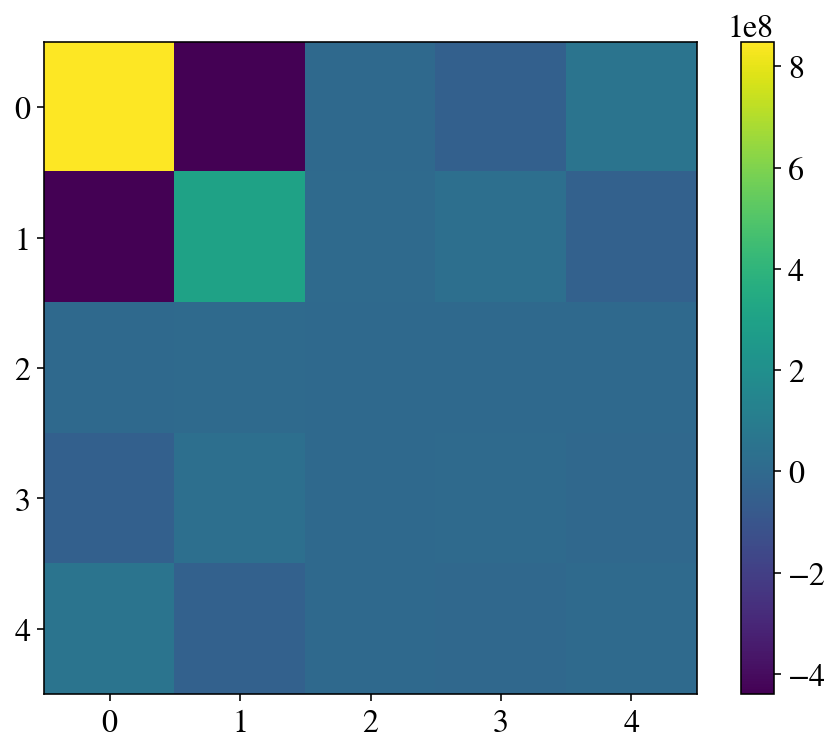

In [276]:
divider = 5

standard_block = Fisher[:divider, :divider]
cross_block = Fisher[:divider, divider:]
perturbation_block = Fisher[divider:, divider:]

fig,ax2 = plt.subplots()

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

m=ax2.imshow(marginalized, origin='upper', cmap=cm.viridis)
fig.colorbar(m)

fig,ax3 = plt.subplots()
m=ax3.imshow(standard_block, origin='upper', cmap=cm.viridis)
fig.colorbar(m)

plt.show()

0.3445855663531179
f00 8.421817684468806
num 1.5559036007396583
Maximum σ^2 for F_00: 0.3816373026797072


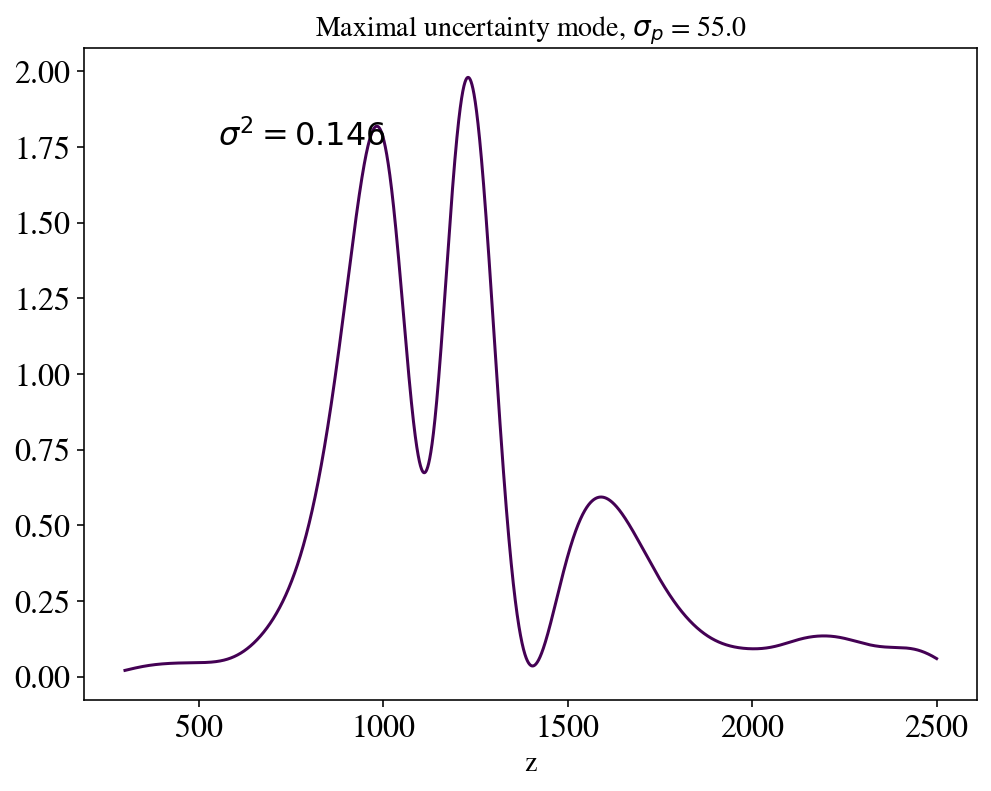

In [277]:
H0_row = marginalized[0,1:]
block = marginalized[1:,1:]
binv = np.linalg.inv(block)

mode = np.einsum("i,ij->j", H0_row, binv)

F_00 = marginalized[0,0]
print(np.sqrt(1/F_00))
num = np.einsum("a,ab,b", H0_row, binv, H0_row)
print("f00 {}".format(F_00))
print("num {}".format(num))
sig2 = num/(F_00*num - num**2)
print("Maximum σ^2 for F_00: {}".format(np.sqrt(sig2)))

gaussian = lambda z, mu, sig, scal : scal*(1./np.sqrt(2*np.pi*sig*sig))*np.exp(-0.5*((z-mu)/sig)**2)

points=[]
for i,z in enumerate(z_of_pert):
    points.append(gaussian(z, z, width, mode[i]))
    
points=np.array(mode)

norm = np.abs(np.einsum("i,ij,j", points.T, binv, points)) ##normalizing the uncertainty to be unit
#norm = np.abs(np.einsum("i,i", points.T, points)) ##normalizing the uncertainty to be unit
#norm=eigenval
points*=1./np.sqrt(norm)

fun = scipy.interpolate.CubicSpline(z_of_pert, points)
zs = np.linspace(zmin_pert, zmax_pert, 10000)

fig,ax=plt.subplots()
ax.plot(zs, fun(zs))
#ax.plot(z_of_pert, points)
#ax.plot(z_of_pert, points1)
ax.set_title(r"Maximal uncertainty mode, $\sigma_p$ = {:.1f}".format(sig_prior), fontsize=14)
ax.set_xlabel("z", fontsize=14)
ax.text(0.15, 0.85, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)
plt.savefig("../results/H0_mode_80b.pdf", dpi=300)

## sigma(H0) is a monotonic function

In [279]:
prior_sigmas = np.linspace(0.001, 50, 100)
H0_sigmas = []

for sig_prior in prior_sigmas:
    Fisher = fsky*np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

    Fprior_block = np.zeros((Npert,Npert))


    for i in np.arange(Npert):
        for j in np.arange(Npert):
            Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-(z_of_pert[i]-z_of_pert[j])**2/sig_prior**2)
    
    Fprior_block = np.linalg.inv(Fprior_block)

    Fprior = np.zeros(Fisher.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher+=Fprior

    divider = 5

    standard_block = Fisher[:divider, :divider]
    cross_block = Fisher[:divider, divider:]
    perturbation_block = Fisher[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)

    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = num/(F_00*num - num**2)
    H0_sigmas.append(np.sqrt(sig2))

H0_sigmas = np.array(H0_sigmas)

15.076301507537687 0.38193334238768645
Max is σ_H0=nan at σ_prior=158.794175879397


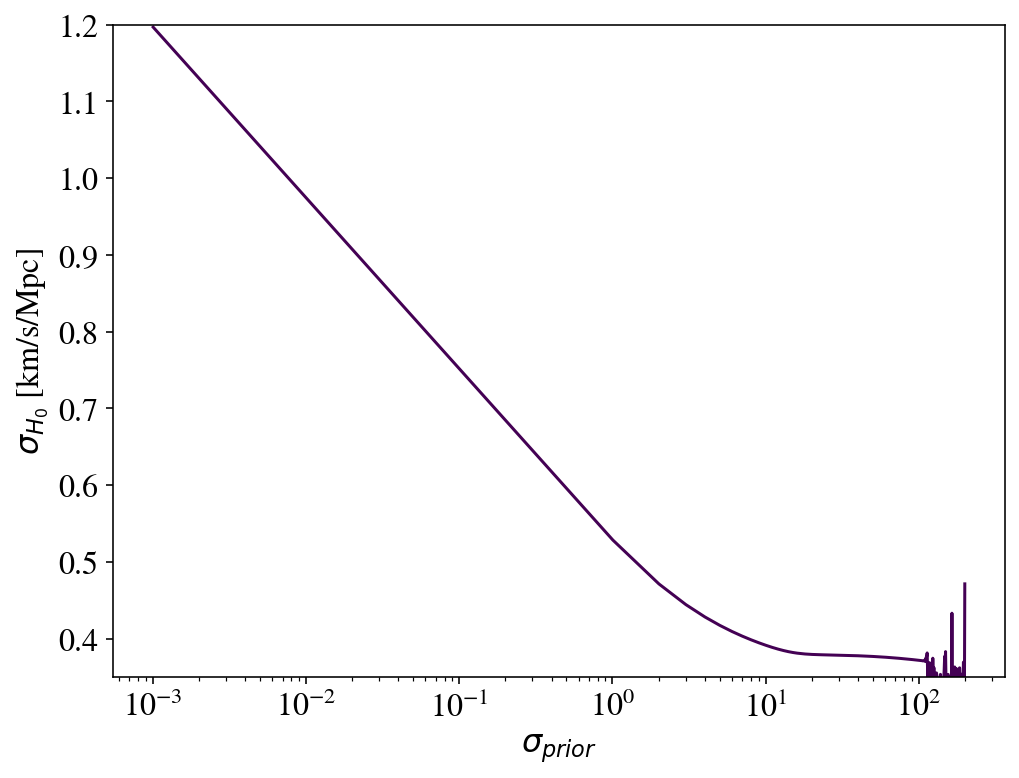

In [156]:
derivative = np.gradient(H0_sigmas, prior_sigmas[1]-prior_sigmas[0])

idx=15
print(prior_sigmas[idx], H0_sigmas[idx])
fig, ax = plt.subplots()
print("Max is σ_H0={} at σ_prior={}".format(np.max(H0_sigmas), prior_sigmas[np.argmax(H0_sigmas)]))
ax.plot(prior_sigmas, H0_sigmas)
#ax.plot(prior_sigmas, derivative[idx]*(prior_sigmas-prior_sigmas[idx])+H0_sigmas[idx])
ax.set_ylim([0.35, 1.2])
ax.set_xlabel("$\sigma_{prior}$")
ax.set_ylabel("$\sigma_{H_0}$ [km/s/Mpc]")
ax.set_xscale('log')
plt.show()


In [46]:
Fisher = fsky*np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

Fstandard = Fisher[:6, :6]

Fs_inv = np.linalg.inv(Fstandard)

def svdsolve(A):
    u, s, v = np.linalg.svd(A)
    Ainv = np.dot(v.transpose(), np.dot(np.diag(s**-1), u.transpose()))
    return Ainv

#Fs_inv = svdsolve(Fstandard)

print("LCDM sigma(H0) is {}".format(np.sqrt(Fs_inv[5,5])))

LCDM sigma(H0) is 0.3445855663531164


## Collecting into a single cell

In [335]:
import scipy.integrate

prior_list = np.logspace(-5,np.log10(2),20)*dz
print(prior_list)
output_dict={}
H0_sig = {}

def apply_norm(norm):
    def dec(f):
        def wrapper(*args, **kwargs):
            return f(*args, **kwargs)/norm
        return wrapper
    return dec

for sig_prior in prior_list:
    ################################
    # Calculate Fisher matrix
    ################################
    print("σ_prior={}".format(sig_prior))
    Fisher = fsky*np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

    ################################
    # Adding a smoothness prior
    ################################

    Fprior_block = np.zeros((Npert,Npert))

    #sig_prior = 1*dz
    for i in np.arange(Npert):
        for j in np.arange(Npert):
            Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(z_of_pert[i]-z_of_pert[j])**2/sig_prior**2)
            #Fprior_block[i,j] = np.exp(-(z_of_pert[i]-z_of_pert[j])**2/sig_prior**2)

    Fprior_block = np.linalg.inv(Fprior_block)
    Fprior = np.zeros(Fisher.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher+=Fprior

    #####################################
    # Marginalizing over standard params
    ######################################

    divider = 5

    standard_block = Fisher[:divider, :divider]
    cross_block = Fisher[:divider, divider:]
    perturbation_block = Fisher[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    #####################################
    # Maximizing confusion
    ######################################

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)

    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    print("\t F_00={}".format(F_00))
    print("\t LCDM σ(H0)={}".format(np.sqrt(1/F_00)))
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    print("\t num={}".format(num))
    sig2 = 1./(F_00 - num)
    #print("Maximum σ^2 for F_00: {}".format(np.sqrt(sig2)))
    H0_sig.update({sig_prior:np.sqrt(sig2)})
    
    print("\t σ(H0)={}".format(np.sqrt(sig2)))
    
    gaussian = lambda z, mu, sig, scal : scal*(1./np.sqrt(2*np.pi*sig*sig))*np.exp(-0.5*((z-mu)/sig)**2)

    points=[]
    for i,z in enumerate(z_of_pert):
        points.append(gaussian(z, z, width, mode[i]))

    points=np.array(mode)

    Id = np.diag([1.]*binv.shape[0])

    norm = np.einsum("i,ij,jk,kl,l", H0_row.T, binv, Id, binv, H0_row)
    print("\t norm={}".format(norm))
    points*=1./np.sqrt(norm)

    fun = scipy.interpolate.CubicSpline(z_of_pert, points)

    output_dict.update({sig_prior: fun})


[2.75000000e-04 5.22798427e-04 9.93884348e-04 1.88945882e-03
 3.59202217e-03 6.82874016e-03 1.29820168e-02 2.46799198e-02
 4.69186301e-02 8.91963129e-02 1.69569789e-01 3.22366616e-01
 6.12846399e-01 1.16507321e+00 2.21490343e+00 4.21072011e+00
 8.00493765e+00 1.52180684e+01 2.89308445e+01 5.50000000e+01]
σ_prior=0.000275
	 F_00=8.421817684468806
	 LCDM σ(H0)=0.3445855663531179
	 num=7.84292501974106
	 σ(H0)=1.3143195766562827
	 norm=115.89739999727233
σ_prior=0.0005227984274184178
	 F_00=8.421817684468806
	 LCDM σ(H0)=0.3445855663531179
	 num=7.78738938802686
	 σ(H0)=1.255476903378003
	 norm=70.75920005532174
σ_prior=0.0009938843480406208
	 F_00=8.421817684468806
	 LCDM σ(H0)=0.3445855663531179
	 num=7.724282007862019
	 σ(H0)=1.1973380590939804
	 norm=41.471903453079975
σ_prior=0.0018894588152415126
	 F_00=8.421817684468806
	 LCDM σ(H0)=0.3445855663531179
	 num=7.655016175072598
	 σ(H0)=1.1419800590894942
	 norm=23.705588773296924
σ_prior=0.003592022171927737
	 F_00=8.421817684468806
	

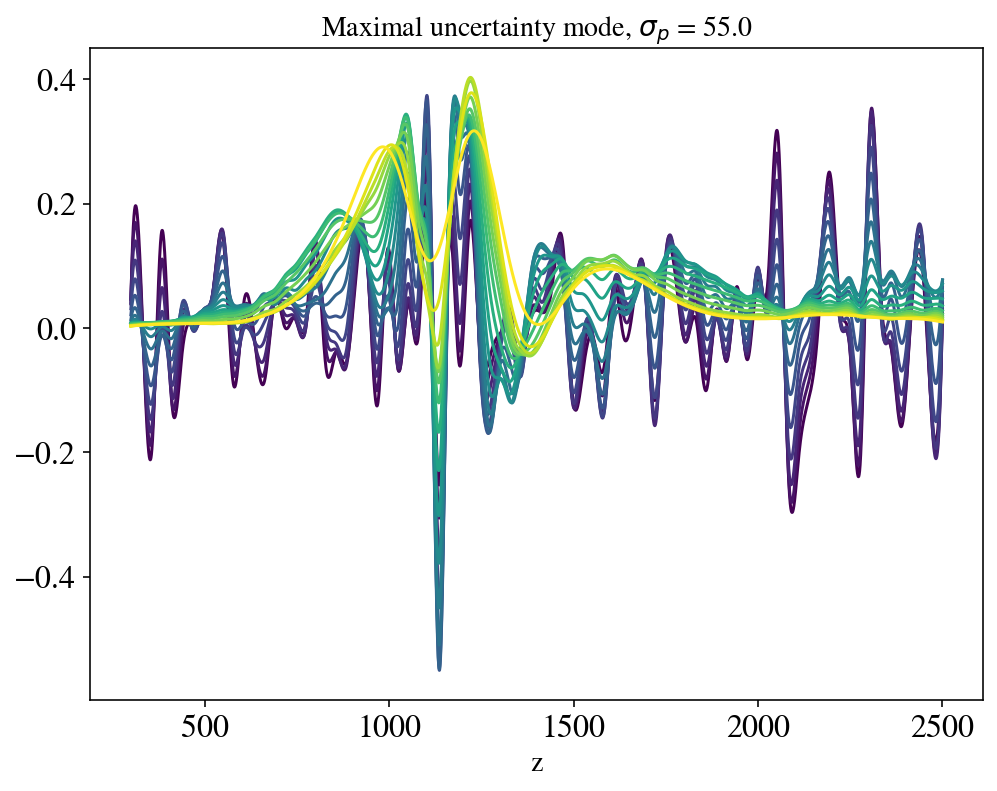

In [336]:
import matplotlib as mpl
import cycler
n = len(output_dict)
color = plt.cm.viridis(np.linspace(0,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

zs = np.linspace(zmin_pert, zmax_pert, 10000)  
fig,ax=plt.subplots()
i=0
for sig, fun in output_dict.items():
    #ax.plot(zs, fun(zs), color="k", alpha=i/(len(output_dict)), label="$\sigma = {}$".format(sig))
    ax.plot(zs, fun(zs), label="$\sigma = {}$".format(sig))

    i+=1

ax.set_title(r"Maximal uncertainty mode, $\sigma_p$ = {:.1f}".format(sig_prior), fontsize=14)
ax.set_xlabel("z", fontsize=14)
#ax.text(0.15, 0.85, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)
#plt.legend()
plt.show()

## Projecting onto principal components

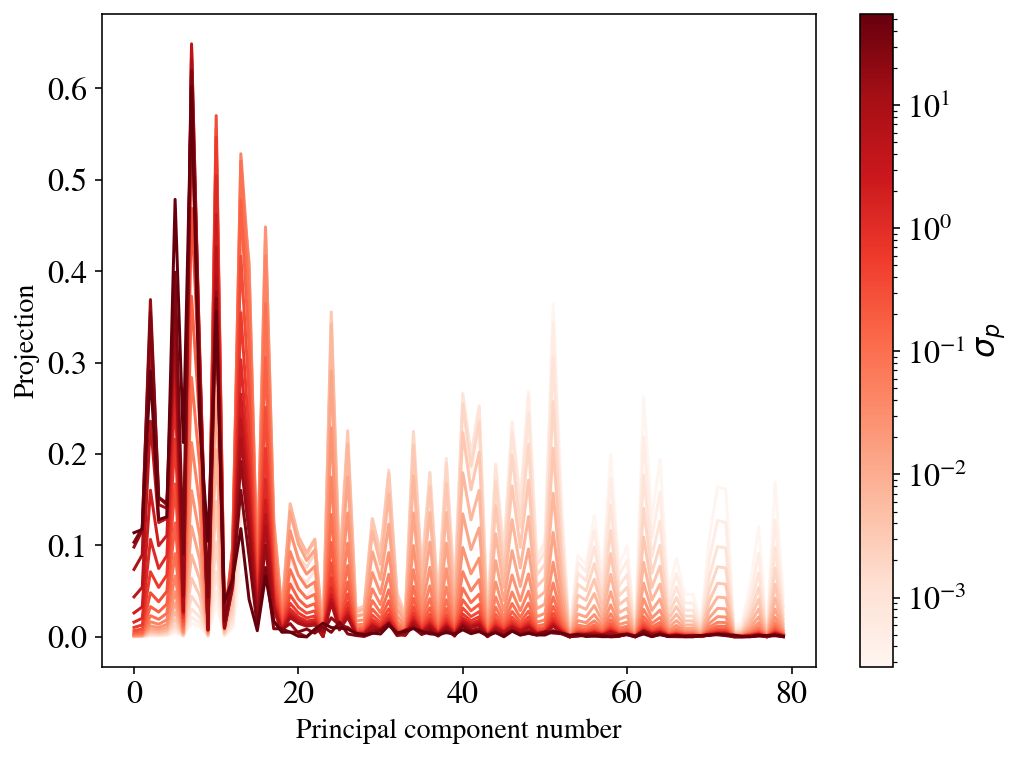

In [341]:
Fisher = fsky*np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

divider = 6
standard_block = Fisher[:divider, :divider]
cross_block = Fisher[:divider, divider:]
perturbation_block = Fisher[divider:, divider:]

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

u, s, vh = np.linalg.svd(marginalized)
    
exem_eigenvals = s**2
exem_matrix = vh

n = len(output_dict)
my_cm = plt.cm.Reds
colorc = my_cm(np.linspace(0,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', colorc)

fig,ax=plt.subplots()
i=0
for sig, fun in output_dict.items():
    projection = np.abs(np.einsum("ij,j->i", exem_matrix, fun(z_of_pert)))
    ax.plot(np.arange(Npert), projection, label="$\sigma={}$".format(sig))
    #ax.scatter(np.arange(Npert), projection, label="$\sigma={}$".format(sig))
    i+=1

sm = plt.cm.ScalarMappable(cmap=my_cm, norm=LogNorm(vmin=prior_list[0], vmax=prior_list[-1]))
cbar = plt.colorbar(sm, label="$\sigma_p$")
ax.set_xlabel("Principal component number", fontsize=14)
ax.set_ylabel("Projection", fontsize=14)
#cbar.ax.set_ylabel('$\sigma_p$', rotation=270)

#plt.legend()
plt.show()